## Uncertainty Estimation

It was shown in the paper that it was possible to obtain reasonably good estimates of the parameters, even with noisy fields values. However, it is crucial for practical application to also have an estimation uncertainty. 

In order to obtain uncertainty estimation values, we need to introduce a Bayesian framework. This requires to introduce some prior distributions over the parameter values. We can immagine to have some nominal values for the components, or at least reasonable guesses or intervals for the values. 

**Proposed Bayesian Solution**:

**MAP estimate** & **Laplace estimate** around the posterior mode. With this approach the prior influences the optimization with via a penalty term on the loss. Gradient based optimization (Adam / LBFGS) can then be employed to find the optimum, which in this case would be the MAP estimate. Finally, we assume the posterior is a Gaussian and we calculate the best fit using the Laplace approximation, which relies on computing the Hessian.

## Prior Distribution Family over the Physical Parameters

In [ ]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import h5py
import numpy as np


# change the working directory to the root of the project
sys.path.append(str(Path.cwd().parent))


from circuit_parameter_estimator.parameters.parameter_class import Parameters

# load measurement interface
from circuit_parameter_estimator.io import Measurement
from circuit_parameter_estimator.noise import add_noise_to_Measurement

from circuit_parameter_estimator.parameters.parameter_transformation import make_log_param, reverse_log_param
from circuit_parameter_estimator.model.model_base import BuckParamEstimator
from circuit_parameter_estimator.model.trainer import Trainer


from circuit_parameter_estimator.io import LoaderH5

### Prior distribution family:
We have to consider **Additive vs. Multiplicative Variation**.

* **Additive variation** means the component deviates by **adding or subtracting** some noise:

  $$
  x = x_0 + \epsilon
  \quad\text{(e.g., } \epsilon \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  This is typical of **normal (Gaussian)** noise.

* **Multiplicative variation** means the component value varies by being **scaled** up or down:

  $$
  x = x_0 \cdot (1 + \delta)
  \quad\text{(e.g., } \delta \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  Or more generally:

  $$
  \log x \sim \mathcal{N}(\mu, \sigma^2)
  \Rightarrow x \sim \text{LogNormal}(\mu, \sigma^2)
  $$

  This results in a **log-normal distribution** in linear space.

Considering how the components are manufactured:

* Component tolerances are often specified **as a percentage** (e.g., ±5%, ±10%).
* This means that the error **scales** with the magnitude.
* Example:

  * A 1 kΩ resistor with 5% tolerance → 950–1050 Ω
  * A 10 kΩ resistor with 5% tolerance → 9500–10500 Ω
    So the **absolute error grows** with the nominal value.

---

### Implication for Priors

If component values are specified with **percentage tolerances**, then we should model the distributions as:

$$
\log(x) \sim \mathcal{N}(\log(x_0), \sigma^2)
\quad\Rightarrow\quad
x \sim \text{LogNormal}
$$

This ensures:

* **Positivity**
* **Correct scaling of uncertainty**
* **Realistic tails** (e.g., 3σ errors reflect real-world max/min limits)


A log-normal distribution is suitable because:

* All parameters are positive
* Datasheet tolerances are multiplicative (e.g. ±20%)

For each parameter θ:

$$
p(\theta) = \frac{1}{\theta \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log \theta - \mu)^2}{2\sigma^2} \right)
$$

Where:

* μ = log(nominal value)
* σ = log(1 + relative tolerance)

## Uniform Prior

If no prior knowledge is available, we can consider the prior to be a uniform distribution over a confidence interval. In this way, the contribution of the prior term is constant and does not influence the loss function minimization. 

This can be useful when we want to focus on finding the best likelihood functions for the data! 

In [ ]:
import matplotlib
from scipy.stats import lognorm
from circuit_parameter_estimator.constants import ParameterConstants, MeasurementGroupArchive
from circuit_parameter_estimator.data_covariance.auxiliary import rel_tolerance_to_sigma

TRUE_PARAMS = ParameterConstants.TRUE
NOMINAL = ParameterConstants.NOMINAL
REL_TOL = ParameterConstants.REL_TOL
PRIOR_SIGMA = rel_tolerance_to_sigma(REL_TOL, number_of_stds_in_relative_tolerance=1) # transforms relative tolerance to the value of the standard deviation

# print the nominal parameters
print("Nominal Parameters:")
print(NOMINAL)

print("Relative Tolerances:")
print(REL_TOL)

Nominal Parameters:
L: <0.00068> - RL: <0.4> - C: <0.00015> - RC: <0.25> - Rdson: <0.25> - Rloads1: <3.3> - Rloads2: <10.0> - Rloads3: <6.8> - Vin: <46.0> - VF: <1.1>
Relative Tolerances:
L: <0.5> - RL: <0.4> - C: <0.5> - RC: <0.5> - Rdson: <0.5> - Rloads1: <0.3> - Rloads2: <0.3> - Rloads3: <0.3> - Vin: <0.3> - VF: <0.3>


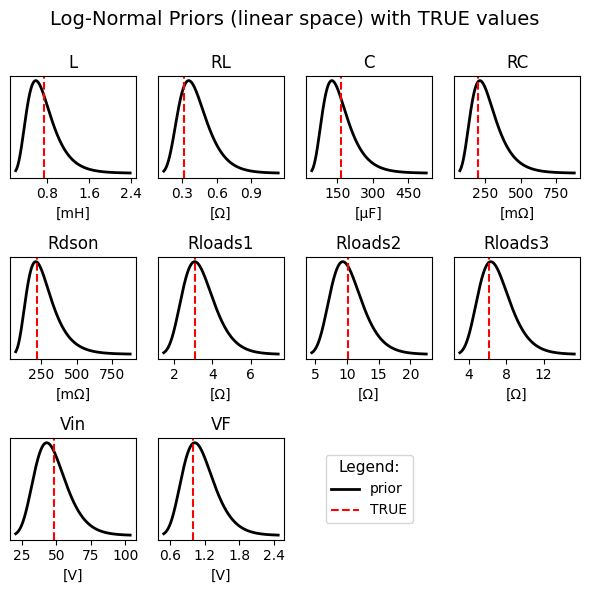

In [ ]:
from circuit_parameter_estimator.parameters.plotting_funcs import plot_parameter_priors

plot_parameter_priors(NOMINAL, PRIOR_SIGMA, TRUE_PARAMS);

# MAP Estimation for Buck Converter Parameters
We want to estimate the **maximum a posteriori** (MAP) value of the latent parameters

$$
z \in \mathbb{R}_{+}^{10}
$$

which represent the physical parameters of the buck converter (e.g., $L, R_L, C, R_C, R_{\mathrm{dson}}, R_{\mathrm{load}}, V_{\mathrm{in}}, V_F, \dots$).

## 1. Bayesian Formulation
Bayes’ rule gives:

$$
p(z \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid z) \, p(z)}{p(\mathcal{D})}
$$

where:

* $\mathcal{D} = \{(x_i, y_i)\}_{i=0}^{N-1}$ is the dataset,
  with $x_i$ the input state ($i_n, v_n, D_n, \Delta t_n$) and $y_i$ the next-step output state ($i_{n+1}, v_{n+1}$),
* $p(\mathcal{D} \mid z)$ is the **likelihood**,
* $p(z)$ is the **prior** over parameters,
* $p(\mathcal{D})$ is the marginal likelihood (evidence).



The marginal likelihood
$$
p(\mathcal{D}) = \int p(\mathcal{D} \mid z) \, p(z) \, dz
$$
is independent of $z$. For a fixed, observed dataset $\mathcal{D}$, this means that **the posterior $p(z \mid \mathcal{D})$ is proportional to the joint distribution $p(\mathcal{D}, z)$**.

Geometrically, if we think of $p(\mathcal{D}, z)$ as a function over the parameter space, **the posterior lies on a level set of the joint distribution corresponding to the observed $\mathcal{D}$**.
In other words, maximizing the posterior is equivalent to finding the point of maximum joint probability on the level set of $p(\mathcal{D}, z)$ where the data coordinate matches our observation.
Thus, the MAP estimate can be written as:
$$
z_{\mathrm{MAP}} = \arg\max_z p(z \mid \mathcal{D}) 
= \arg\max_z p(\mathcal{D}, z)
$$
without computing the intractable marginal $p(\mathcal{D})$.


## 2. Supervised Model and Likelihood Factorization

We assume the system is described by:

$$
y = f(x, z)
$$

where $f$ is the **physics-based forward model** (in our case, the RK4-integrated buck converter equations).

The likelihood for the full dataset factorizes as:

$$
p(\mathcal{D} \mid z) = \prod_{i=0}^{N-1} p(y_i \mid x_i, z)
$$

under the assumptions that:

1. **Measurements are conditionally independent** given $z$,
2. **Noise is identically distributed** across all observations.


## 3. Negative Log Posterior (MAP Objective)

Minimizing the **negative log posterior** is equivalent to MAP estimation:

$$
\text{NLL}(z) = -\log p(z \mid \mathcal{D})
= -\log p(\mathcal{D} \mid z) - \log p(z) + \text{const}.
$$

This splits naturally into:

$$
\text{NLL}(z) =
\underbrace{-\log p(\mathcal{D} \mid z)}_{\text{data term}}
\;+\;
\underbrace{-\log p(z)}_{\text{prior term}}
\;+\; \text{const}.
$$

### 3.1 Likelihood Term

We assume **additive, homoscedastic Gaussian sensor noise**:

$$
y_i \mid x_i, z \;\sim\; \mathcal{N}\!\bigl(f(x_i, z), \sigma_x^2 I \bigr)
$$

where $\sigma_x^2$ is the measurement noise variance.

The data term is:

$$
\text{data term} =
\frac{1}{2\sigma_x^2} \sum_{i=0}^{N-1} \| y_i - f(x_i, z) \|^2.
$$

### 3.2 Prior Term

We place **log-normal priors** on the parameters:

$$
\log z_k \sim \mathcal{N}(\mu_{0,k}, \sigma_{0,k}^2), \quad k = 1, \dots, 10
$$

which ensures:

* **Positivity** of parameters,
* Multiplicative variability (relative deviations matter more than absolute deviations).

The prior term is:

$$
\text{prior term} =
\frac{1}{2} \sum_{k=1}^{10} \frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}.
$$

### 3.3 Full MAP Objective

The complete MAP loss is therefore:

$$
\text{NLL}(z) =
\frac{1}{2\sigma_x^2} \sum_{i=0}^{N-1} \| y_i - f(x_i, z) \|^2
+ \frac{1}{2} \sum_{k=1}^{10} \frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

## 4. Data–Prior Trade-off

We can rewrite:

$$
\text{NLL}(z) =
\sum_{i=0}^{N-1} \| y_i - f(x_i, z) \|^2
+ \underbrace{\frac{\sigma_x^2}{\sigma_0^2}}_{\lambda} \sum_{k=1}^{10} (\log z_k - \mu_{0,k})^2
+ \text{const}
$$

where $\sigma_0$ is a representative prior standard deviation.

The parameter $\lambda = \frac{\sigma_x^2}{\sigma_0^2}$ controls the **relative weight of the prior**:

* If data is **noisy** ($\sigma_x^2 \uparrow$), $\lambda$ increases → prior dominates.
* If data is **clean** ($\sigma_x^2 \downarrow$), $\lambda$ decreases → likelihood dominates.

Here, $\sigma_x$ and $\sigma_0$ have **physical interpretations**:

* $\sigma_x$ from sensor specs or repeated measurements,
* $\sigma_0$ from datasheet ranges or manufacturing tolerances.

## From Posterior on Observed Data to Posterior on Residuals

In the MAP framework, we have been working with the **posterior distribution** over parameters $z$ given the observed dataset $\mathcal{D} = \{(x_i, y_i)\}_{i=0}^{N-1} $.
The likelihood term was built from the discrepancy between measured outputs $y_i$ and the physics-based model predictions $f(x_i, z)$.

We now reformulate this likelihood in terms of **residuals**, which will become the main objects of interest in our model.

### 1. Defining Residuals

In the simplest case, we define the residual for each observation $(x_i, y_i)$ as:

$$
r_i(z) = y_i - f(x_i, z)
$$

which measures the misfit between the forward model output (given parameters $z$) and the actual measurement.

However, **one of the main reasons to switch to the residual-based posterior** is that the residuals need not be limited to this basic definition.
By working in residual space, we can:

* Define **different types of residuals** (e.g., forward prediction errors, backward prediction errors, differences between two physics-based integrations).
* Explicitly capture **cross-correlations** between different residual types in a joint covariance structure.
* Model **structured noise** (e.g., temporal correlation, cross-variable correlation, heteroscedasticity).
* Combine multiple sources of information (e.g., sensor data and physics constraints) into a **unified likelihood** through their residuals.

In the following, we will use $r_i(z)$ to denote a generic residual, which may be this simple misfit or a more elaborate definition depending on the modeling objective.

### 2. Likelihood in Terms of Residuals

Under the standard i.i.d. Gaussian noise model:

$$
y_i \mid x_i, z \;\sim\; \mathcal{N}(f(x_i, z), \sigma_x^2 I)
$$

the residuals satisfy:

$$
r_i(z) \;\sim\; \mathcal{N}(0, \sigma_x^2 I).
$$

The likelihood for the entire dataset can then be written directly in terms of residuals:

$$
p(\mathcal{D} \mid z)
= \prod_{i=0}^{N-1} \frac{1}{(2\pi\sigma_x^2)^{m/2}}
\exp\!\left(-\frac{1}{2\sigma_x^2} \| r_i(z) \|^2\right),
$$

where $m$ is the number of outputs per observation ($m=2$ for $(i,v)$).

Taking logs:

$$
\log p(\mathcal{D} \mid z)
= -\frac{1}{2\sigma_x^2} \sum_{i=0}^{N-1} \| r_i(z) \|^2 + \text{const}.
$$

### 3. Distribution on Residuals

We can now interpret the data likelihood as **the probability density of the residual vector**:

$$
R(z) =
\begin{bmatrix}
r_0(z) \\
r_1(z) \\
\vdots \\
r_{N-1}(z)
\end{bmatrix}
\in \mathbb{R}^{Nm}.
$$

If we generalize the noise model, we can replace the simple i.i.d. Gaussian assumption with:

$$
R(z) \;\sim\; \mathcal{N}\bigl(0, \Sigma_r\bigr)
$$

where $\Sigma_r$ is the full residual covariance matrix. This allows:

* Off-diagonal entries to capture **correlation across time** and **between different measured variables**.
* Different variances for different components (heteroscedasticity).
* More complex residual definitions that combine multiple error sources.

The log-likelihood becomes:

$$
\log p(R(z) \mid z)
= -\frac12 R(z)^\top \Sigma_r^{-1} R(z) - \frac12 \log |\Sigma_r| + \text{const}.
$$


### 4. MAP in the Residual Space

The posterior on parameters given the residuals is:

$$
p(z \mid R_{\mathrm{obs}}) \propto p(R_{\mathrm{obs}} \mid z) \, p(z).
$$

Taking negative logs:

$$
\text{NLL}(z) =
\underbrace{\frac12 R(z)^\top \Sigma_r^{-1} R(z) + \frac12 \log |\Sigma_r|}_{\text{data term in residual space}}
+ \underbrace{\frac12 \sum_{k=1}^{10} \frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}}_{\text{prior term}}
+ \text{const}.
$$

If $\Sigma_r = \sigma_x^2 I$, this reduces to:

$$
\text{NLL}(z) =
\frac{1}{2\sigma_x^2} \sum_{i=0}^{N-1} \| r_i(z) \|^2
+ \frac12 \sum_{k=1}^{10} \frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

### 5. Why This Matters

Recasting the likelihood in terms of residuals allows us to:

1. **Go beyond simple pointwise misfit** by incorporating forward/backward consistency, differences between multiple model variants, or other composite error measures into the definition of $r_i(z)$.
2. **Model structured correlations** in the residuals explicitly through $\Sigma_r$.
3. **Use robust likelihoods** (e.g., Student-$t$, Laplace) for outlier resistance.
4. Integrate **multiple measurement types** into one probabilistic formulation.

## Noisy Observations

In practice, both the **input state** $x_n$ and the **target state** $y_n = x_{n+1}$ are measured with noise.
In our setup, each state vector contains the inductor current $i$ and the capacitor voltage $v$, so

$$
x_n^{\text{obs}} =
\begin{bmatrix}
i_n^{\text{obs}}\\[1pt]
v_n^{\text{obs}}
\end{bmatrix},
\qquad
y_n^{\text{obs}} =
\begin{bmatrix}
i_{n+1}^{\text{obs}}\\[1pt]
v_{n+1}^{\text{obs}}
\end{bmatrix}.
$$

We use a deterministic physics-based model $f(z, x_n)$ (RK4 integrator) to predict the next state.
The residual between the noisy target and the prediction from noisy inputs is

$$
r_n(z) = f\bigl(z,\,x_n^{\text{obs}}\bigr) - x_{n+1}^{\text{obs}}.
$$

### 1. Independent noise on $i$ and $v$

Current and voltage sensors can have different noise levels, so we model the **state noise covariance** at each time step as

$$
\Sigma_x = \mathrm{diag}\!\bigl(\sigma_i^2,\;\sigma_v^2\bigr),
$$

where $\Sigma_x$ is defined for a **single observed state vector** and represents the per-time-step sensor noise.
We assume no cross-channel correlation in the measurement noise.

Let

$$
J \;=\; \frac{\partial f}{\partial x}
= \begin{bmatrix}
J_{11} & J_{12}\\[2pt]
J_{21} & J_{22}
\end{bmatrix} \in \mathbb{R}^{2\times 2}
$$

be the Jacobian of the model output with respect to the input state, evaluated at $x_n$.
This is **not** a time derivative; it measures the *sensitivity* of the one-step prediction to small perturbations in $i_n$ and $v_n$.

### 2. Propagation of measurement noise into the residuals

If the true states are noise-free $(\tilde{x}_n, \tilde{y}_n)$ and the sensor noise is white Gaussian and independent across time steps, then a first-order Taylor expansion of $f$ around $\tilde{x}_n$ gives:

$$
f\bigl(x_n^{\text{obs}}\bigr) \;\approx\; f(\tilde{x}_n) + J \,\varepsilon_n,
$$

where $\varepsilon_n \sim \mathcal{N}(0,\Sigma_x)$ is the input noise.

The residual built from noisy measurements is then

$$
r_n^{\text{obs}} \;=\; \underbrace{f(\tilde{x}_n) - \tilde{x}_{n+1}}_{r_n\ \text{(ideal residual)}} \;+\; J\,\varepsilon_n \;-\; \varepsilon_{n+1},
$$

and since $\varepsilon_n$ and $\varepsilon_{n+1}$ are independent, the residual noise term

$$
\epsilon_r = J\,\varepsilon_n - \varepsilon_{n+1}
$$

has covariance

$$
\boxed{
\Sigma_r \;=\; \Sigma_x + J\,\Sigma_x\,J^\top
}
$$

Here, $\Sigma_r$ is the **per-step residual covariance** under our chosen definition of residuals.
It depends on the measurement noise covariance $\Sigma_x$ and on the Jacobian $J$, and in general will not be diagonal because $J$ can mix current and voltage noise.

### 3. Interpretation

* The **first term** $\Sigma_x$ represents noise directly contaminating the target measurement.
* The **second term** $J\,\Sigma_x\,J^\top$ is **propagated input noise** — even with a deterministic model, uncertainty in the current state produces uncertainty in the next-state prediction proportional to the model’s Jacobian.
* The off-diagonal terms of $\Sigma_r$ capture the fact that noise in $i$ can induce error in $v$ prediction, and vice versa.


### 4. Dataset structure and transient-dependent noise

In our data, we observe $B$ separate **transients**, each of length $T$ time steps.
The model input tensor $X$ therefore has shape

$$
[B,\,T,\,4]
$$

corresponding to $(i_n, v_n, D_n, \Delta t_n)$ for each step in each transient.

Each transient is measured with a different load resistance $R_{\mathrm{load}}$, which affects:

* The Jacobian $J$ (since the dynamics depend on $R_{\mathrm{load}}$),
* The propagation of noise from $(i, v)$ to the prediction,
* Possibly the sensor noise levels themselves if they vary with operating conditions.

Thus, in the most general case, $\Sigma_r$ — and hence the likelihood — can vary from one transient to another.



## Brief Note on Forward and Backward Predictions

In the derivation in the original paper, both forward and backward predictions were considere. In this way we have two residuals:
\begin{align}
r_{fwd} &= x_{n+1}^{fwd} - x_{n+1}^{obs} \\
r_{bck} &= x_{n}^{bck} - x_{n}^{obs} \\
\end{align}

However,  even **with noise at $n$ and $n{+}1$**, forward and backward one-step residuals don’t give you two independent pieces of information. They’re just two different linear combinations of the **same** noise terms, using both tends to double-count and can bias the MAP.

### Toy Example

Let's consider a model where $x_{k+1}=\alpha x_k+\beta$.

Define
* forward residual $r_f(k)=\alpha\,y_k+\beta-y_{k+1}$
* backward residual $r_b(k)=(y_{k+1}-\beta)/\alpha - y_k$

For **any** data $y_k,y_{k+1}$ (noise or not) and any $\alpha,\beta$ used consistently in both formulas,

$$
r_b(k) = -\frac{1}{\alpha}\, r_f(k)\quad\text{(exact identity).}
$$

So their sample correlation is exactly $-1$. Adding measurement noise $\varepsilon_k,\varepsilon_{k+1}$ does not change this dependence; it just changes the value of $r_f$.

**Statistically:** Using both $r_f$ and $r_b$ with the **correct joint covariance** (including cross-terms) is equivalent to using the pair $(y_k,y_{k+1})$ once. It **doesn’t add information** beyond those two observations—it just repackages them.

Indeed, in the following, let's compare the results we obtain by minimizing only the fwd prediction:

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2}$$

and compare with a term that considers both forward and backward terms: 

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2} + \bigl\|r_n^{\text{bw}}\bigr\|^{2}$$

In the second case, we double the weight of the prior in order to compensate for doubling the data information. 

Since the **PRIOR is the same additional term**, we focus on **the LIKELIHOOD** and compare the runs optimized using: 
1) only **forward loss**
2) averaging **forward and backward loss**


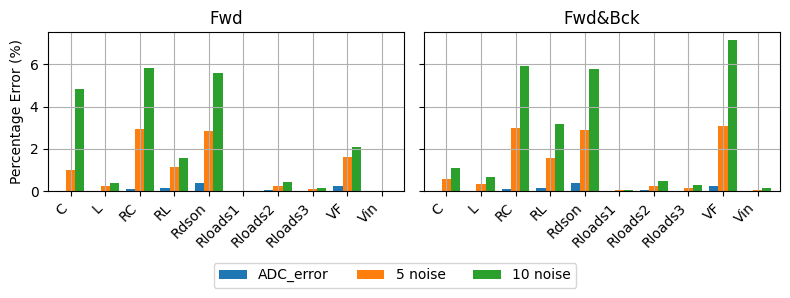

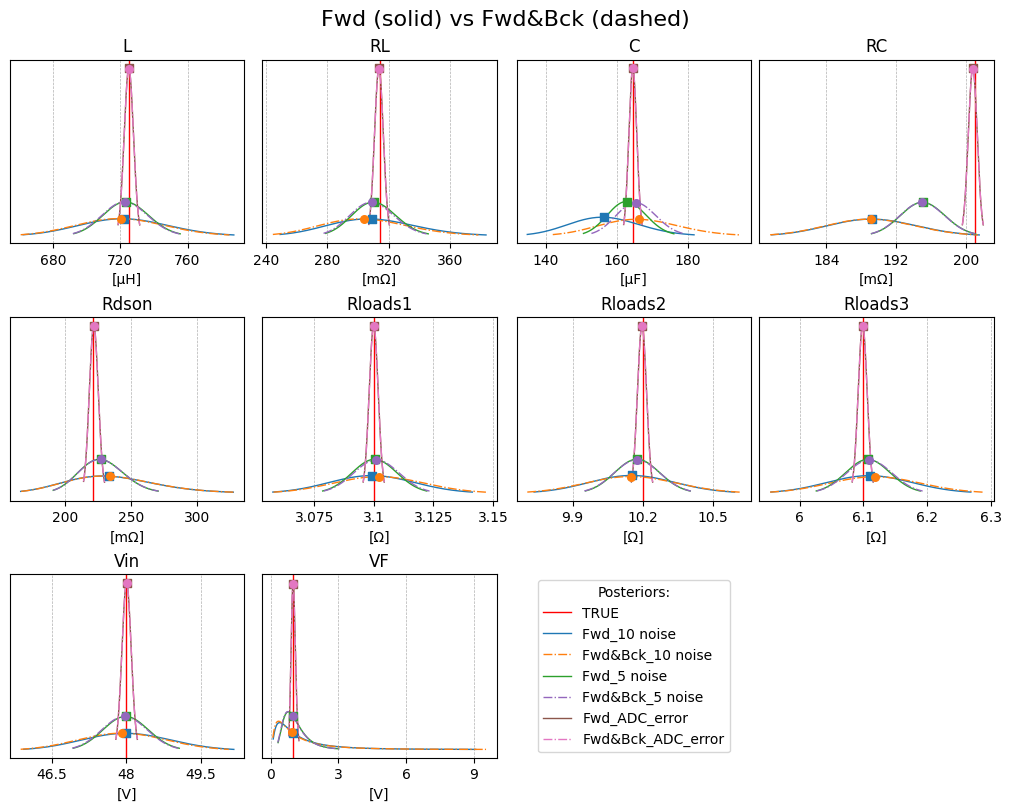

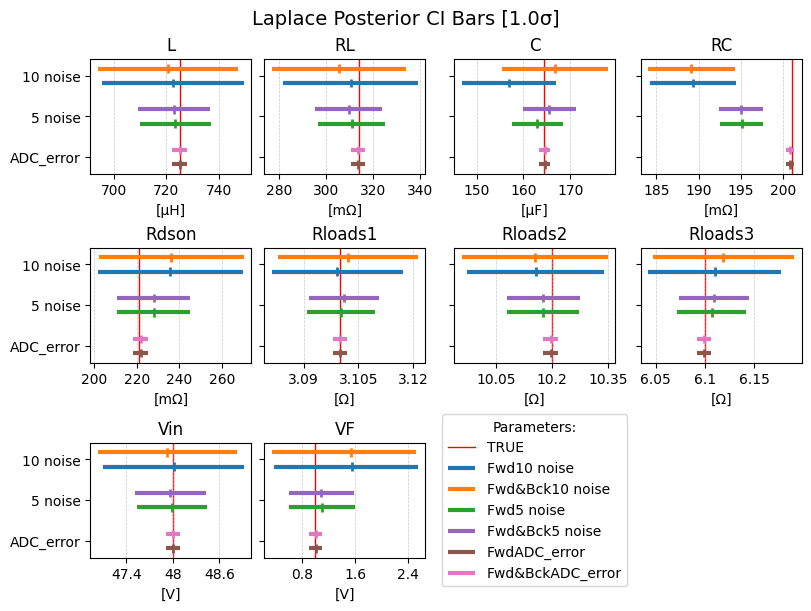

In [ ]:
from circuit_parameter_estimator.model_results.history import TrainingHistory
from circuit_parameter_estimator.model_results.ploting_comparisons import ResultsComparerTwo
from circuit_parameter_estimator.laplace_posterior_plotting_comparison import LaplaceResultsComparer


out_directory = Path.cwd().parent / "RESULTS" / "LIKELIHOODS" 
directory_dictionary = {
    "Fwd": out_directory / "FWD",
    "Fwd&Bck": out_directory / "FWD&BCK"
}
rc = ResultsComparerTwo.from_dirs(directory_dictionary)
# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bottom_inch=0.1
)

# Optional: tracked parameters for specific curves
# fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels, figsize=(10, 8))

laplace_comparer = LaplaceResultsComparer.from_dirs(directory_dictionary)
laplace_comparer.plot_posteriors_grid(
    # skip_labels=("ADC_error",),
    ncols=4,
    # prior_mu=NOMINAL,
    # prior_sigma=PRIOR_SIGMA,
    true_params=TRUE_PARAMS,
);
laplace_comparer.plot_ci(
    # skip_labels=("ADC_error",),
    ncols=4, 
    true_params=TRUE_PARAMS,
    figsize=(8, 6)
);

It is worth noting that if we don't know anything about the covariance matrix of the residuals, so we use the **identity matrix**: 
$$\Sigma_x \sim I_2$$

Then it seems that averaging the forward and backward estimations might make the **predictions more robust**. 
However, this is a **small effect if we inspect the posterior distributions**.

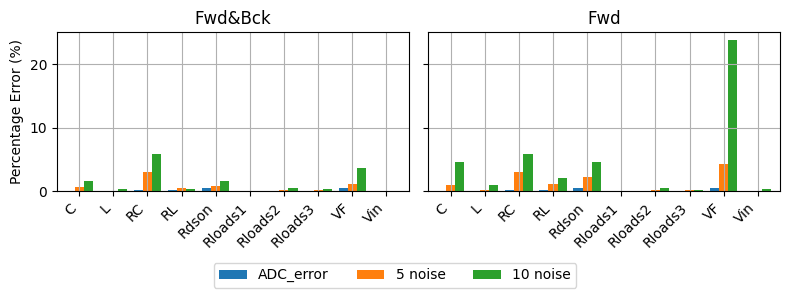

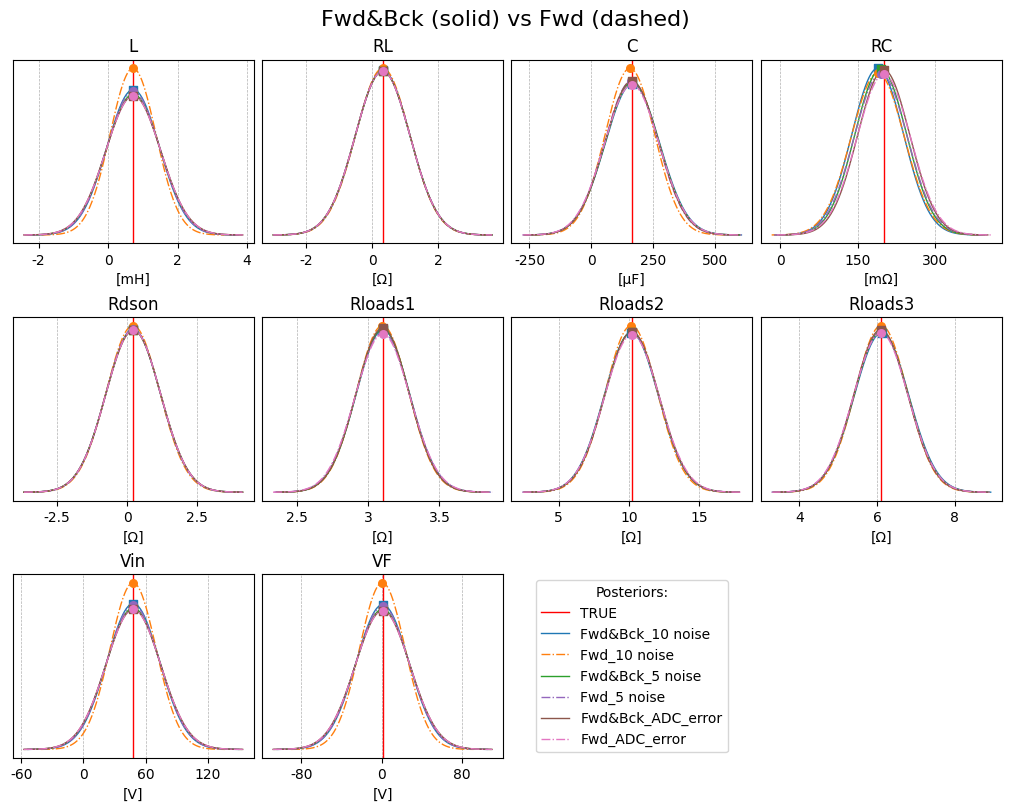

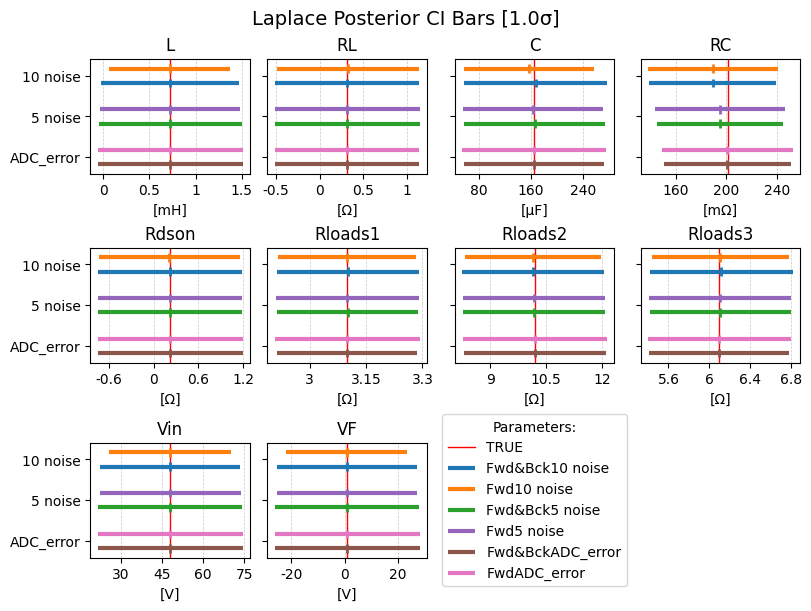

In [ ]:
from circuit_parameter_estimator.model_results.history import TrainingHistory
from circuit_parameter_estimator.model_results.ploting_comparisons import ResultsComparerTwo
# from pinn_buck.plot_aux import place_shared_legend

out_directory = Path.cwd().parent / "RESULTS" / "LIKELIHOODS"
directory_dict = {
    "Fwd&Bck": out_directory / "FWD&BCK_EYE",
    "Fwd": out_directory / "FWD_EYE",
}

rc = ResultsComparerTwo.from_dirs(directory_dict)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bottom_inch=0.1
);

# Optional: tracked parameters for specific curves


# fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels);

laplace_comparer = LaplaceResultsComparer.from_dirs(directory_dict)
laplace_comparer.plot_posteriors_grid(
    # skip_labels=("ADC_error",),
    ncols=4,
    # prior_mu=NOMINAL,
    # prior_sigma=PRIOR_SIGMA,
    true_params=TRUE_PARAMS,
    distribution_type="gaussian"
);
laplace_comparer.plot_ci(
    # skip_labels=("ADC_error",),
    ncols=4,
    true_params=TRUE_PARAMS,
    figsize=(8, 6),
    distribution_type="gaussian"
);

# Optimization with Preconditioning: Adam and LBFGS

## 1. Preconditioning and Curvature

Gradient descent updates are given by

$$
\theta_{t+1} = \theta_t - \eta \nabla \mathcal{L}(\theta_t).
$$

When the loss surface is **ill-conditioned** (large ratio between the largest and smallest curvature directions), plain gradient descent struggles: steps oscillate along steep directions and barely move along flat ones.

A **preconditioner** $P$ modifies the update as

$$
\theta_{t+1} = \theta_t - \eta P \nabla \mathcal{L}(\theta_t).
$$

The role of $P$ is to transform the gradient into a better search direction.

* In quadratic optimization, the *ideal* choice is

  $$
  P = H^{-1},
  $$

  where $H$ is the Hessian. This yields the Newton step, which converges in one iteration.
* In practice, exactly computing $H^{-1}$ is infeasible for large-scale problems. Optimizers instead construct **approximations of a useful preconditioner**.

Two common strategies are Adam (moment-based diagonal scaling) and LBFGS (quasi-Newton Hessian approximation).


## 2. Adam: Moment-Based Diagonal Preconditioning

Adam belongs to the family of **adaptive gradient methods**. It does not attempt to approximate curvature. Instead, it rescales updates by tracking per-parameter gradient statistics:

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, 
\qquad
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2,
$$

with update

$$
\theta_{t+1} = \theta_t - \eta \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}.
$$

### Effective preconditioner

The update can be seen as

$$
P_t = \operatorname{diag}\!\left(\tfrac{1}{\sqrt{v_t} + \epsilon}\right).
$$

* Each coordinate gets its **own learning rate** depending on past gradient magnitudes.
* $P_t$ is strictly **diagonal**: parameter correlations are ignored.
* This improves robustness to scaling but cannot capture rotated curvature directions.

**Use cases** - Adam is particularly effective in:

* high-dimensional models,
* stochastic mini-batch training,
* early optimization phases where robustness and speed are critical.

It is less effective when the Hessian has strong **off-diagonal structure**, since its diagonal preconditioner cannot exploit correlations.


## 3. LBFGS: Curvature-Aware Preconditioning

Quasi-Newton methods such as BFGS explicitly aim to approximate curvature. The update is

$$
\theta_{t+1} = \theta_t - \eta H_t^{-1} \nabla \mathcal{L}(\theta_t),
$$

where $H_t^{-1}$ is a running approximation of the inverse Hessian.

* Full BFGS maintains a dense Hessian estimate.
* LBFGS is a memory-efficient variant: it stores only a limited history of gradient and parameter differences, from which it reconstructs a low-rank approximation of $H_t^{-1}$.

### Effective preconditioner

Here,

$$
P \approx H_t^{-1},
$$

so the preconditioner captures both **scaling and rotations**. This is crucial when eigenvectors of $H$ are not aligned with coordinate axes.

---

### Toy Example: Rotated Quadratic

Consider a 2-parameter loss

$$
\mathcal{L}(a,b) = \tfrac12 \, r^\top \Sigma^{-1} r, 
\qquad
r(\theta) = \begin{bmatrix}a \\ b\end{bmatrix}.
$$

#### Case 1. Diagonal precision ($\Sigma^{-1} = I$)

$$
\mathcal{L}(a,b) = \tfrac12 (a^2 + b^2), 
\quad
H = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}.
$$

Eigenvectors align with axes, so Adam’s diagonal preconditioner matches curvature well.


#### Case 2. Correlated precision

$$
\Sigma^{-1} =
\begin{pmatrix}1 & \rho \\ \rho & 1\end{pmatrix}, 
\quad \rho = 0.9.
$$

The Hessian is

$$
H = \begin{pmatrix}1 & \rho \\ \rho & 1\end{pmatrix}.
$$

Eigenvalues: $\lambda_1 = 1+\rho, \; \lambda_2 = 1-\rho$.
Eigenvectors:

$$
v_1 = \tfrac{1}{\sqrt2}\begin{bmatrix}1 \\ 1\end{bmatrix}, 
\quad
v_2 = \tfrac{1}{\sqrt2}\begin{bmatrix}1 \\ -1\end{bmatrix}.
$$

These are rotated by ±45° relative to the axes.

* **Adam** only rescales axes separately → cannot align with rotated directions. It overshoots along steep $v_1$ and stalls along flat $v_2$.
* **LBFGS** builds $H_t^{-1}$ → can rotate updates to follow eigenvectors directly, achieving stable progress.

---

### When LBFGS works well

* Smooth, deterministic loss functions where curvature is reliable.
* Medium-scale problems where limited history storage is feasible.
* Fine-tuning near a minimum, where curvature exploitation yields superlinear convergence.

## 4. Why Combine Adam and LBFGS?

The two methods complement each other:

1. **Adam phase** — rapidly reduces loss using noisy gradients and adapts learning rates per parameter.
2. **LBFGS phase** — once near a solution, switches to curvature-aware refinement for stable and precise convergence.

This combines **robust exploration** (Adam) with **efficient exploitation** (LBFGS), which is especially effective in parameter estimation and physics-informed training.


## Adam + LBFGS fit

In [ ]:
from typing import Callable, Iterable
import torch

from circuit_parameter_estimator.io import LoaderH5
from circuit_parameter_estimator.parameters.parameter_transformation import make_log_param, reverse_log_param
from circuit_parameter_estimator.data_covariance.jacobian_estimation import JacobianEstimator
from circuit_parameter_estimator.data_covariance.covariance_matrix_function_archive import (
    covariance_matrix_on_basic_residuals,
    generate_residual_covariance_matrix,
    chol,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %%
## Noise Power
lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2


noise_power_dict = {
    "ADC_error": (noise_power_ADC_i, noise_power_ADC_v),
    "5 noise": (noise_power_5_i, noise_power_5_v),
    "10 noise": (noise_power_10_i, noise_power_10_v),
}


# load measurements
db_dir = Path.cwd().parent.parent / "Databases"
h5filename = "buck_converter_Shuai_processed.h5"
io = LoaderH5(db_dir, h5filename)
model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)


covariance_matrices = []
jacobian_estimator = JacobianEstimator()

for label, data_covariance in noise_power_dict.items():
    io.load(label)
    X = torch.tensor(io.M.data, device=device)
    jac = jacobian_estimator.estimate_Jacobian(
        X, model, number_of_samples=500, dtype=torch.float64
    )[
        ..., :2, :2
    ]  # keep a size of (T, 2, 2)

    covariance_matrix = generate_residual_covariance_matrix(
        data_covariance=data_covariance,
        residual_covariance_func=covariance_matrix_on_basic_residuals,
        jac=jac,
        dtype=torch.float64,
    )

    covariance_matrices.append(covariance_matrix)

def print_transient_covariance_matrices(covariance_matrices: torch.Tensor):
    for i in range(covariance_matrices.shape[0]):
        print(f"Transient {i+1} Covariance Matrix:")
        print(covariance_matrices[i])


for name, matrices in zip(["ADC noise", "5 LSB noise", "10 LSB noise"], covariance_matrices):
    print(f"Covariance matrices for {name}:")
    print_transient_covariance_matrices(matrices)
    print("-" * 40)

l_dict = {
    key:
    # chol(torch.eye(2))
    chol(cov_matrix)
    for key, cov_matrix in zip([1, 3, 4], covariance_matrices)
}

Covariance matrices for ADC noise:
Transient 1 Covariance Matrix:
tensor([[ 1.1737e-05, -9.4679e-07],
        [-9.4679e-07,  1.0157e-04]], dtype=torch.float64)
Transient 2 Covariance Matrix:
tensor([[ 1.1744e-05, -9.7485e-07],
        [-9.7485e-07,  1.0455e-04]], dtype=torch.float64)
Transient 3 Covariance Matrix:
tensor([[ 1.1742e-05, -9.6799e-07],
        [-9.6799e-07,  1.0382e-04]], dtype=torch.float64)
----------------------------------------
Covariance matrices for 5 LSB noise:
Transient 1 Covariance Matrix:
tensor([[ 2.9320e-04, -2.3670e-05],
        [-2.3670e-05,  2.5389e-03]], dtype=torch.float64)
Transient 2 Covariance Matrix:
tensor([[ 2.9336e-04, -2.4371e-05],
        [-2.4371e-05,  2.6136e-03]], dtype=torch.float64)
Transient 3 Covariance Matrix:
tensor([[ 2.9331e-04, -2.4200e-05],
        [-2.4200e-05,  2.5952e-03]], dtype=torch.float64)
----------------------------------------
Covariance matrices for 10 LSB noise:
Transient 1 Covariance Matrix:
tensor([[ 1.1728e-03, -9.46

In [ ]:
# %%
import torch
from typing import Dict

from circuit_parameter_estimator.model.residuals import basic_residual
from circuit_parameter_estimator.model.loss_function_archive import loss_whitened
from circuit_parameter_estimator.model.trainer import Trainer, TrainingConfigs
from circuit_parameter_estimator.constants import ParameterConstants, MeasurementGroupArchive
from circuit_parameter_estimator.model.trainer import Trainer, TrainingConfigs
from circuit_parameter_estimator.laplace_posterior_fitting import LaplaceApproximator, LaplacePosterior
from circuit_parameter_estimator.model.map_loss import MAPLoss
from circuit_parameter_estimator.constants import MeasurementGroupArchive

def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)
out_dir = Path.cwd().parent / "RESULTS" / "LIKELIHOODS" / "FWD_no_hooks"
out_dir.mkdir(parents=True, exist_ok=True)

run_configs = TrainingConfigs(
    lr_adam=1e-3,
    epochs_adam=10_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor_adam=0.5,
    epochs_lbfgs=100,
    lr_lbfgs=1,
    history_size_lbfgs=20,
    max_iter_lbfgs=100,
    clip_gradient_adam=1e6,
    save_every_lbfgs=1,
)

noisy_measurements = {}
trained_models = {}
trained_runs = {}
laplace_posteriors: Dict[str, LaplacePosterior] = {}

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, group_number in enumerate(l_dict.keys()):
    group_name = MeasurementGroupArchive.SHUAI_ORIGINAL[group_number]
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X = torch.tensor(io.M.data, device=device)
    model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)

    L = l_dict[group_number]

    map_loss = MAPLoss(
        initial_params=ParameterConstants.NOMINAL,
        initial_sigma=PRIOR_SIGMA,
        loss_likelihood_function=loss_whitened,  # loss function for the forward-backward pass
        residual_function=basic_residual,
        L=L,  # Cholesky factor of the diagonal noise covariance matrix
    ).likelihood

    trainer = Trainer(
        model=model,
        map_loss=map_loss,
        cfg=run_configs,
        device=device,
    )

    trainer.fit(X=X)

    ### fit a Laplace Approximator for the posterior
    print("Fitting Laplace Posterior")
    laplace_posterior_approx = LaplaceApproximator(
        model=trainer.optimized_model(),
        loss_fn=trainer.map_loss,
        device=device,
        damping=1e-7,
    )
    laplace_posterior = laplace_posterior_approx.fit(X)
    laplace_posterior.save(out_dir / f"laplace_posterior_{group_name}.json")

    laplace_posteriors[group_name] = laplace_posterior
    trained_models[group_name] = trainer.optimized_model()
    trained_runs[group_name] = trainer.history

    trainer.history.get_best_parameters().save(out_dir / f"best_params_{group_name}.json")
    trainer.history.save(out_dir / f"history_{group_name}")
    print("\n \n \n")

Loading group 1: ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 0, gradient_norm  nan, loss 1.289212e+05,
Parameters: L=6.800e-04, RL=4.000e-01, C=1.500e-04,  RC=2.500e-01, Rdson=2.500e-01,  Rloads=[3.300e+00, 1.000e+01, 6.800e+00],  Vin=46.000, VF=1.100e+00
[Adam] Iteration 1000, gradient_norm 1.190735e+03, loss 9.153395e+01,
Parameters: L=7.294e-04, RL=3.360e-01, C=1.644e-04,  RC=2.008e-01, Rdson=2.040e-01,  Rloads=[3.100e+00, 1.019e+01, 6.098e+00],  Vin=48.157, VF=1.053e+00
[Adam] Iteration 2000, gradient_norm 2.798150e+02, loss 6.586905e+01,
Parameters: L=7.279e-04, RL=3.235e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.117e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.088, VF=1.055e+00
[Adam] Iteration 3000, gradient_norm 8.046101e+01, loss 5.984304e+01,
Parameters: L=7.270e-04, RL=3.166e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.195e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.066, VF=1.054e+00
[Adam] I

c:\Users\tomas\anaconda3\envs\EM+\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


[LBFGS] Iteration 14, gradient_norm 5.023262e+00, loss 5.917687e+01,
Parameters: L=7.250e-04, RL=3.135e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.218e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.005, VF=9.974e-01
[LBFGS] Iteration 15, gradient_norm 5.023262e+00, loss 5.917687e+01,
Parameters: L=7.250e-04, RL=3.135e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.218e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.005, VF=9.974e-01
[LBFGS] Iteration 16, gradient_norm 5.023262e+00, loss 5.917687e+01,
Parameters: L=7.250e-04, RL=3.135e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.218e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.005, VF=9.974e-01
[LBFGS] Iteration 17, gradient_norm 5.023262e+00, loss 5.917687e+01,
Parameters: L=7.250e-04, RL=3.135e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.218e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.005, VF=9.974e-01
[LBFGS] Iteration 18, gradient_norm 5.023262e+00, loss 5.917687e+01,
Parameters: L=7.250e-04, RL=3.135e-01, C=1.

c:\Users\tomas\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\laplace_posterior_plotting.py:914: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


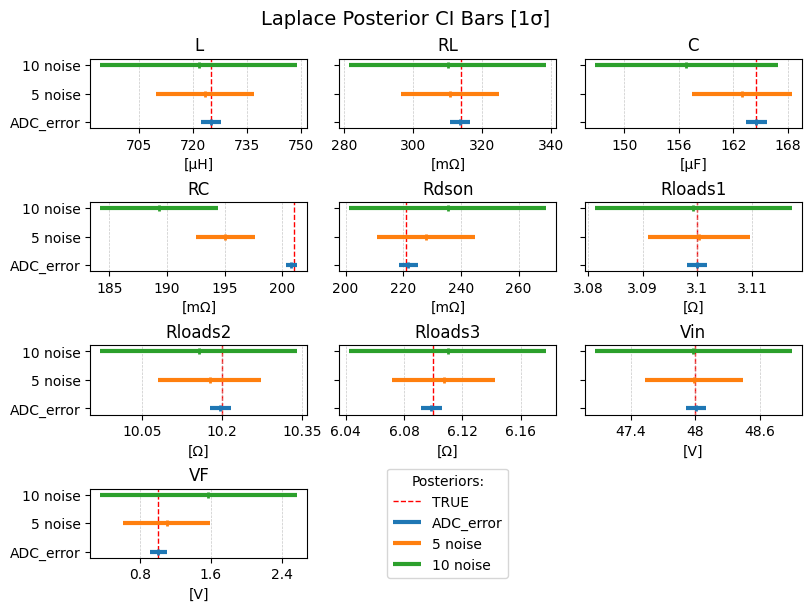

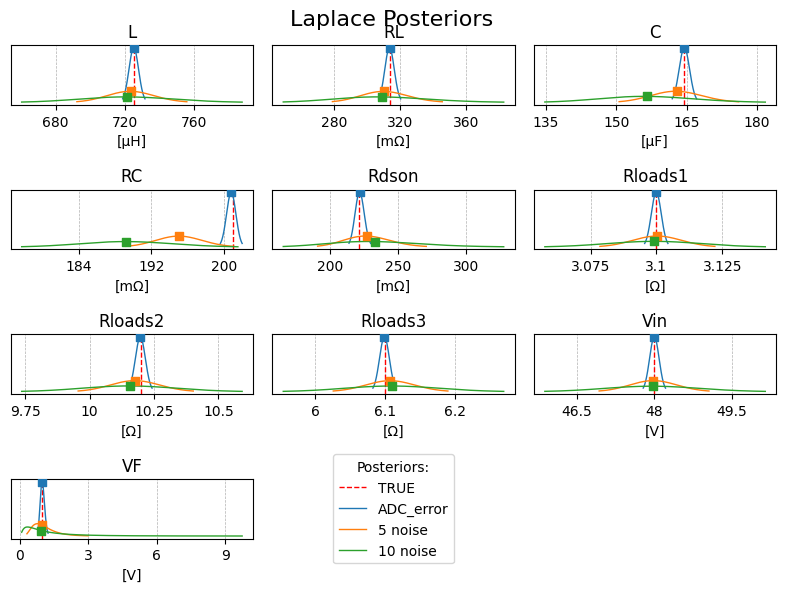

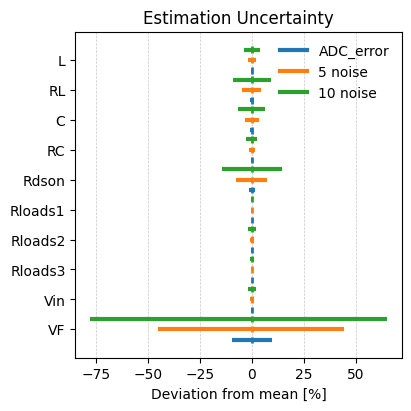

In [ ]:
from circuit_parameter_estimator.laplace_posterior_plotting import LaplacePosteriorPlotter

out_directory = Path.cwd().parent / "RESULTS" / "LIKELIHOODS"
save_dir = out_directory / "FWD_no_hooks"

lplotter = LaplacePosteriorPlotter.from_dir(save_dir)

lplotter.plot_ci(n_sigma=1, ncols=3, true_params=TRUE_PARAMS, figsize=(8,6));
lplotter.plot_laplace_posteriors(true_params=TRUE_PARAMS, ncols=3, figsize=(8,6));
lplotter.plot_uncertainty_percent(figsize=(4,4));

## Laplace Posterior Approximation

In Bayesian inference, the **Laplace approximation** provides a tractable way to approximate a complicated posterior distribution with a Gaussian centered around its **mode** (the MAP estimate).

Given data $\mathcal{D}$ and parameters $\theta$, the posterior is

$$
p(\theta \mid \mathcal{D}) \propto p(\mathcal{D} \mid \theta) \, p(\theta).
$$

Computing this distribution directly is often intractable. The Laplace method instead uses a **second-order Taylor expansion** of the log-posterior around the MAP estimate $\hat{\theta}$:

$$
\log p(\theta \mid \mathcal{D}) \approx \log p(\hat{\theta} \mid \mathcal{D})
- \tfrac{1}{2} (\theta - \hat{\theta})^\top H (\theta - \hat{\theta}),
$$

where

$$
H = - \nabla^2_{\theta} \log p(\theta \mid \mathcal{D}) \big|_{\theta = \hat{\theta}}
$$

is the Hessian of the negative log-posterior at $\hat{\theta}$.

This yields a Gaussian approximation:

$$
p(\theta \mid \mathcal{D}) \approx \mathcal{N}\big(\hat{\theta}, \, H^{-1}\big).
$$

### NOTE
> local approximation (valid near $\hat{\theta}$), may **underestimate uncertainty in multimodal or skewed posteriors**.

For example it seems that $R_C$ is strongly connected to the value of $C$ in this case: the uncertainty for $R_C$ is very low, but it drifts significantly with different estimations of $C$


In [ ]:
lplotter.ci_dataframe(n_sigma=1)

,param,mean,lower,upper,minus [%],plus [%],label
0,L,0.000725,0.000722,0.000728,-0.381814,0.381818,ADC_error
1,RL,0.313517,0.310638,0.316396,-0.918217,0.918233,ADC_error
2,C,0.000165,0.000163,0.000166,-0.681230,0.681221,ADC_error
3,RC,0.200792,0.200277,0.201306,-0.256273,0.256286,ADC_error
4,Rdson,0.221825,0.218412,0.225238,-1.538662,1.538666,ADC_error
5,Rload1,3.099950,3.098051,3.101850,-0.061264,0.061278,ADC_error
6,Rload2,10.196932,10.177426,10.216440,-0.191299,0.191307,ADC_error
7,Rload3,6.098730,6.091648,6.105813,-0.116127,0.116143,ADC_error
8,Vin,48.005104,47.912342,48.097862,-0.193233,0.193225,ADC_error
9,VF,1.001979,0.905795,1.098149,-9.599439,9.598018,ADC_error


In [ ]:
# Print Laplace posterior parameter estimates

print("Laplace Posterior Parameter Estimates:")
for label, lfit in laplace_posteriors.items():
    print(f"\nParameter estimates for {label}:")
    print("LOGNORMAL APPROX:")
    lfit.print_param_uncertainty("lognormal")
    print("GAUSSIAN APPROX:")
    lfit.print_param_uncertainty("gaussian")
    print("\n\n")

Laplace Posterior Parameter Estimates:

Parameter estimates for ADC_error:
LOGNORMAL APPROX:
L         : 7.250e-04  -2.8e-06/+2.8e-06  (-0.38 %, +0.38 %)
RL        : 3.135e-01  -2.9e-03/+2.9e-03  (-0.92 %, +0.92 %)
C         : 1.645e-04  -1.1e-06/+1.1e-06  (-0.68 %, +0.68 %)
RC        : 2.008e-01  -5.1e-04/+5.1e-04  (-0.26 %, +0.26 %)
Rdson     : 2.218e-01  -3.4e-03/+3.4e-03  (-1.54 %, +1.54 %)
Rload1    : 3.100e+00  -1.9e-03/+1.9e-03  (-0.06 %, +0.06 %)
Rload2    : 1.020e+01  -2.0e-02/+2.0e-02  (-0.19 %, +0.19 %)
Rload3    : 6.099e+00  -7.1e-03/+7.1e-03  (-0.12 %, +0.12 %)
Vin       : 4.801e+01  -9.3e-02/+9.3e-02  (-0.19 %, +0.19 %)
VF        : 1.002e+00  -9.6e-02/+9.6e-02  (-9.60 %, +9.60 %)
GAUSSIAN APPROX:
L         : 7.250e-04  ±2.8e-06  (0.38 %)
RL        : 3.135e-01  ±2.9e-03  (0.92 %)
C         : 1.645e-04  ±1.1e-06  (0.68 %)
RC        : 2.008e-01  ±5.1e-04  (0.26 %)
Rdson     : 2.218e-01  ±3.4e-03  (1.54 %)
Rload1    : 3.100e+00  ±1.9e-03  (0.06 %)
Rload2    : 1.020e+01  ±2.0e

## MAP Estimations
Until now we extracted the maximum likelihood estimation of the parameters. 

We can simply add the prior term to the loss function to obtain MAP approximations. 
Note that we can also interpret our results as MAP estimates, where the prior distribution is a uniform distribution over a tolerance range: in this way, the contribution to the loss function is constant and does not affect the minimum. 

In [11]:
set_seed(123)
out_dir = Path.cwd().parent / "RESULTS" / "MAP" / "FWD_no_hooks"
out_dir.mkdir(parents=True, exist_ok=True)

run_configs = TrainingConfigs(
    lr_adam=1e-3,
    epochs_adam=10_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor_adam=0.5,
    epochs_lbfgs=100,
    lr_lbfgs=1,
    history_size_lbfgs=20,
    max_iter_lbfgs=100,
    clip_gradient_adam=1e6,
    save_every_lbfgs=1,
)

noisy_measurements = {}
trained_models = {}
trained_runs = {}
laplace_posteriors: Dict[str, LaplacePosterior] = {}

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, group_number in enumerate(l_dict.keys()):
    group_name = MeasurementGroupArchive.SHUAI_ORIGINAL[group_number]
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X = torch.tensor(io.M.data, device=device)
    model = BuckParamEstimator(param_init=ParameterConstants.NOMINAL).to(device)

    L = l_dict[group_number]

    map_loss = MAPLoss(
        initial_params=ParameterConstants.NOMINAL,
        initial_sigma=PRIOR_SIGMA,
        loss_likelihood_function=loss_whitened,  # loss function for the forward-backward pass
        residual_function=basic_residual,
        L=L,  # Cholesky factor of the diagonal noise covariance matrix
    )

    trainer = Trainer(
        model=model,
        map_loss=map_loss,
        cfg=run_configs,
        device=device,
    )

    trainer.fit(X=X)

    ### fit a Laplace Approximator for the posterior
    print("Fitting Laplace Posterior")
    laplace_posterior_approx = LaplaceApproximator(
        model=trainer.optimized_model(),
        loss_fn=trainer.map_loss,
        device=device,
        damping=1e-7,
    )
    laplace_posterior = laplace_posterior_approx.fit(X)
    laplace_posterior.save(out_dir / f"laplace_posterior_{group_name}.json")

    laplace_posteriors[group_name] = laplace_posterior
    trained_models[group_name] = trainer.optimized_model()
    trained_runs[group_name] = trainer.history

    trainer.history.get_best_parameters().save(out_dir / f"best_params_{group_name}.json")
    trainer.history.save(out_dir / f"history_{group_name}")
    print("\n \n \n")

Loading group 1: ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 0, gradient_norm  nan, loss 1.289212e+05,
Parameters: L=6.800e-04, RL=4.000e-01, C=1.500e-04,  RC=2.500e-01, Rdson=2.500e-01,  Rloads=[3.300e+00, 1.000e+01, 6.800e+00],  Vin=46.000, VF=1.100e+00
[Adam] Iteration 1000, gradient_norm 1.198132e+03, loss 9.214228e+01,
Parameters: L=7.294e-04, RL=3.360e-01, C=1.644e-04,  RC=2.008e-01, Rdson=2.040e-01,  Rloads=[3.100e+00, 1.019e+01, 6.098e+00],  Vin=48.157, VF=1.053e+00
[Adam] Iteration 2000, gradient_norm 2.779801e+02, loss 6.647577e+01,
Parameters: L=7.279e-04, RL=3.235e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.117e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.089, VF=1.056e+00
[Adam] Iteration 3000, gradient_norm 7.966862e+01, loss 6.047152e+01,
Parameters: L=7.270e-04, RL=3.166e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.196e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.067, VF=1.054e+00
[Adam] I

c:\Users\tomas\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\laplace_posterior_plotting.py:914: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


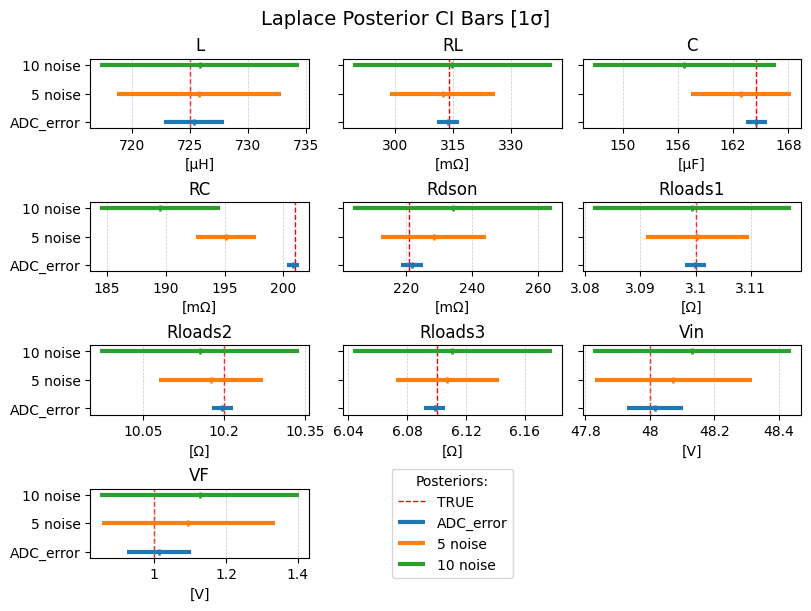

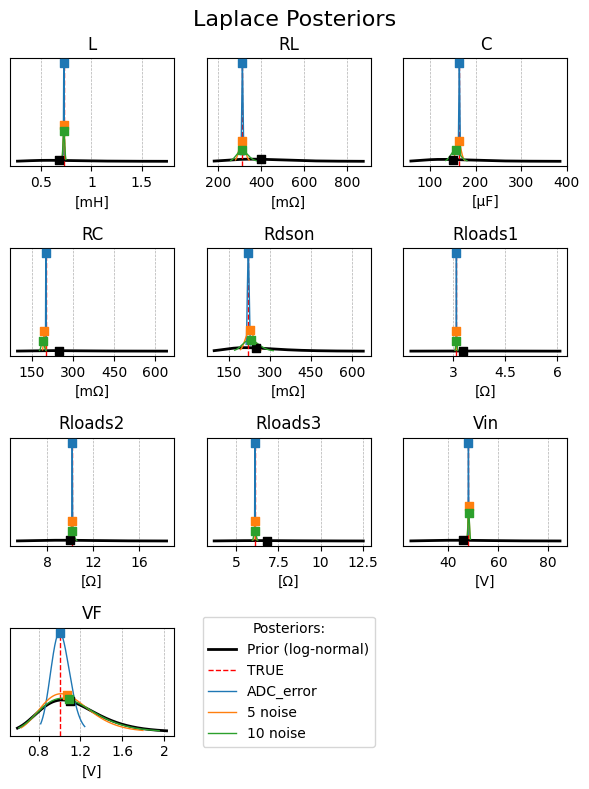

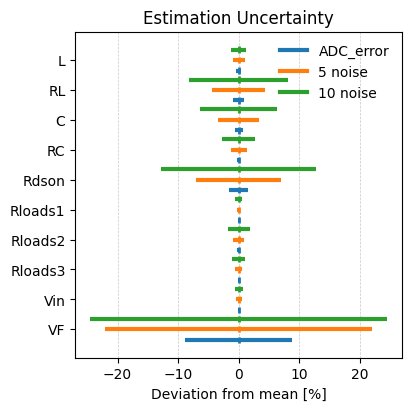

In [12]:
out_directory = Path.cwd().parent / "RESULTS" / "MAP"
save_dir = out_directory / "FWD_no_hooks"

lplotter = LaplacePosteriorPlotter.from_dir(save_dir)

lplotter.plot_ci(n_sigma=1, ncols=3, true_params=TRUE_PARAMS, figsize=(8, 6))
lplotter.plot_laplace_posteriors(true_params=TRUE_PARAMS, ncols=3, figsize=(6, 8), prior_mu=ParameterConstants.NOMINAL, prior_sigma=PRIOR_SIGMA);
lplotter.plot_uncertainty_percent(figsize=(4, 4));

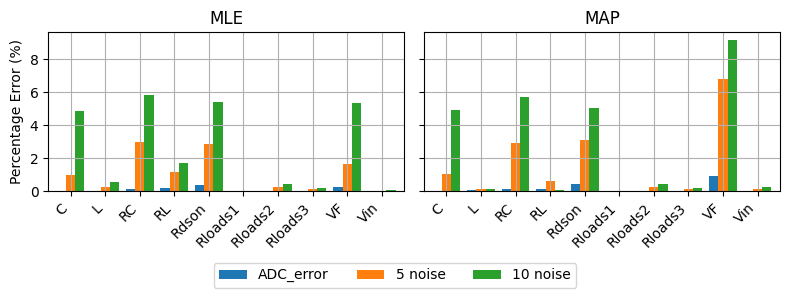

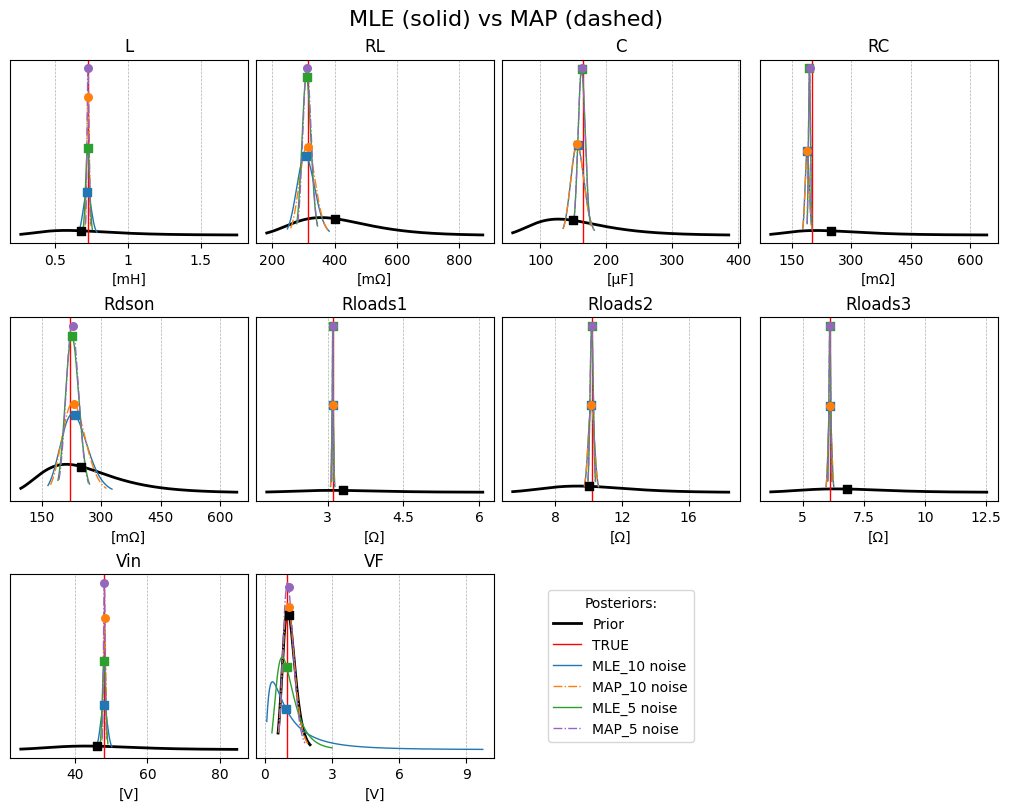

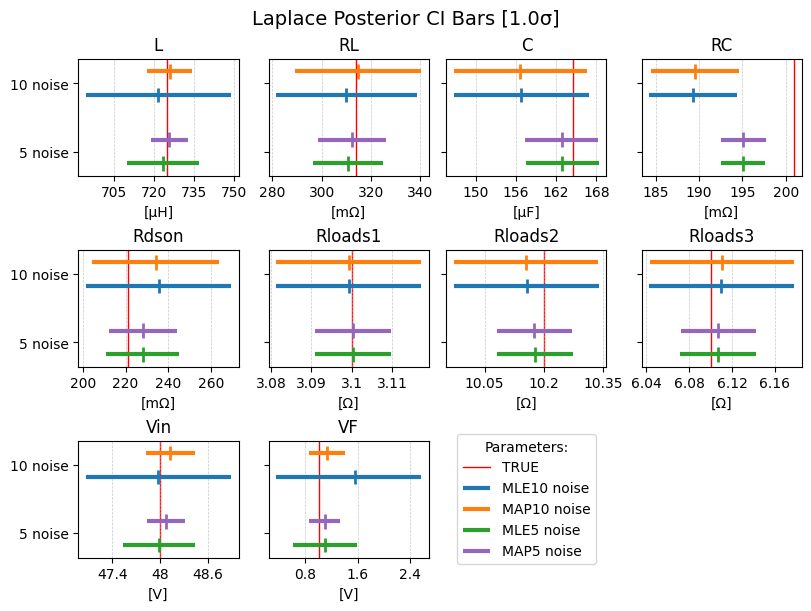

In [13]:
out_directory = Path.cwd().parent / "RESULTS"


directory_dict = {
    "MLE": out_directory / "LIKELIHOODS" / "FWD_no_hooks",
    "MAP": out_directory / "MAP" / "FWD_no_hooks",
}

rc = ResultsComparerTwo.from_dirs(directory_dict)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bottom_inch=0.1
)

# Optional: tracked parameters for specific curves


# fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels);

laplace_comparer = LaplaceResultsComparer.from_dirs(directory_dict)
laplace_comparer.plot_posteriors_grid(
    skip_labels=("ADC_error",),
    ncols=4,
    prior_mu=NOMINAL,
    prior_sigma=PRIOR_SIGMA,
    true_params=TRUE_PARAMS,
);
laplace_comparer.plot_ci(
    skip_labels=("ADC_error",),
    ncols=4,
    true_params=TRUE_PARAMS,
    figsize=(8, 6),
);

## Summary of key Points: 

In this notebook, we: 

* **Introduced the problem**: we want to estimate circuit parameters and their uncertainties from observed signals from the circuit
* **Set up a Bayesian framework**: A log-normal prior is assigned to the parameters and the optimization loss function as defined to have a minimum which coincides with the MAP estimate. It is also shown that using both forward and backward estimation is not informative with respect to the objective, so we focus only on the forward estimation. The optimization is defined in terms of residuals 
    $$
    r = x^{\text{(pred)}}-x^{\text{(obs)}}
    $$ 
    And the covariance matrix of the residuals was defined theoretically from the noise present in the data:
    $$
    \begin{bmatrix}
    i_n^{\text{noise}}\\[1pt]
    v_n^{\text{noise}}
    \end{bmatrix}
    \rightarrow 
    \Sigma_x = \mathrm{diag}\!\bigl(\sigma_i^2,\;\sigma_v^2\bigr)
    \rightarrow \Sigma_r(\Sigma_x, z) 
    $$
* **Introduced Adam and LBFGS Optimization Methods**: The Adam and LBFGS optimization methods were introduced and strengths/weaknesses were explored. 
* **Fitted Noisy Runs**: We put everything together and fitted a set of measurements with increasing noise levels using Adam + LFBGS, considering only the likelihood loss or **uniform priors**.
* **Laplace Posterior for Uncertainty Estimation**: For a fast uncertainty estimation of the parameters, the Laplace method was introduced and applied to the found optimum parameters. We obtain confidence intervals and posterior distributions on the parameter values. 
* **Fitting with Log-Norm priors**: we run fit the same data, this time considering log-norm priors. 